# 基于DCNN的轴承故障诊断方法研究
### 数据——CWRU 轴承故障数据
- 数据采集：fs=12k Hz， 转速：fr = 1750 rpm/min

### 算法——深度卷积神经网络 Deep Convolutional Neural Network

### 描述：“end-to-end” 直接对轴承的振动信号作为特征进行训练

##### step1: 构造样本 在旋转机械故障诊断中，样本长度的选取，理论上每一个样本只要包含旋转一周的点数，所以通常情况通过
$$
Sample_{point} = \frac {Fs * 60} { fr } 
$$
结合本例，通过如下计算，只要样本点大于411就行
$$
Sample_{point} = \frac {Fs * 60} { fr }  = \frac {12000 * 60} {1750} = 411.42
$$
由于计算机特有的属性，我们通常选取2的幂次方进行选取数据点，本次选用了**$1024 = 2^{10} $**个点

##### step2 : 样本划分，即，训练集、测试集、验证集，理论上应该包含三个集合，解释一下这三个集
---
训练集：计算loss

测试集：测试模型

验证集：验证模型泛化能力

---

在很多深度学习的案例中，通常只使用了训练集training set 和测试集 testing set

至于在**训练集** 和**测试集** 样本比例划分没有绝对参考，如：9:1，8:2，7:3等都可以尝试

反而可以作为一个参数敏感性进行分析

**注意**：在研究新模型时，样本比例也应该作为一个参数敏感性进行分析，我曾经在做联邦学习的故障诊断时，对样本比例参数也做过分析，比例较低时，所得效果确实很差

##### step3: DCNN模型构建，即，卷积+池化的交替堆叠，+ 铺平层 + 全连接层 + 输出层(softmax)

模型的选取没有绝对标准，正如何为大样本和小样本，DCNN的网络结构深与浅也没有绝对界限


##### step4: 模型训练和测试，即，前向传播和反向传播

##### step5: 模型的泛化能力验证，即，
> 1 模型是否发生过拟合或欠拟合，通过loss曲线判断 \
> 2 模型的准确率，通过accuracy曲线，混淆矩阵，ROC曲线 \
> 3 模型的解释性，通常通过t-SNE可视化卷积层后的特征

**想法**：我曾在做联邦学习的故障诊断时，为了解释模型，做过每一层weight和bias的数理统计，做了每一层的分布来解释规律，不知道能否用解释CNN模型


### 深度学习框架有很多，tensorflow，pytorch，deepNet， jax，...，我习惯用tensorflow，谷歌开发的框架yyds

In [10]:
# 可以安装库
# !pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 2.5 MB/s eta 0:00:0000:0100:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 957.2/957.2 kB 2.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 4.9 MB/s eta 0:00:0000:0100:01m

[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: pip install --upgrade pip


In [24]:
import tensorflow as tf
import numpy as np

import sklearn

import matplotlib.pyplot as plt

print(tf.__version__)

2.10.0


In [2]:
data = np.loadtxt("./fault_data/CSWU_4Class.txt")
print(data.shape)

(1600, 1024)


In [15]:
# Create training sets and testing sets ratio: 8: 2
train_data = np.vstack((data[0: 320, :], data[400: 720, :], data[800: 1120, :], data[1200: 1520, :]))
test_data = np.vstack((data[320: 400, :], data[720: 800, :], data[1120: 1200, :], data[1520: 1600, :]))

train_data = train_data.reshape((1280, 1,  1024, 1))
test_data = tf.reshape(test_data, (320, 1, 1024, 1))

print(train_data.shape, test_data.shape)

# make label
train_label = np.vstack((np.zeros((320, 1), dtype = int), np.full((320, 1), 1), np.full((320, 1), 2), np.full((320, 1), 3)))
test_label = np.vstack((np.zeros((80, 1), dtype = int), np.full((80, 1), 1), np.full((80, 1), 2), np.full((80, 1), 3)))

train_label = train_label.reshape(-1)
test_label = test_label.reshape(-1)

print(train_label.shape, test_label.shape)

# 打乱样本
train_data, train_label = sklearn.utils.shuffle(train_data, train_label, random_state= 1)

(1280, 1, 1024, 1) (320, 1, 1024, 1)
(1280,) (320,)


In [32]:
# CNN model
# conv1 - conv2 - pool1 - conv3 - conv4 - pool2 - flatten - dense1- dense2 - softmax

init_weight = tf.keras.initializers.RandomNormal()

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(4, (1, 11), activation='relu'))
model.add(tf.keras.layers.Conv2D(4, (1, 5), activation='relu', kernel_initializer = init_weight))
# model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.MaxPooling2D((1, 2)))
model.add(tf.keras.layers.Conv2D(8, (1, 3), activation='relu',kernel_initializer = init_weight))
model.add(tf.keras.layers.Conv2D(8, (1, 3), activation='relu', kernel_initializer = init_weight))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.MaxPooling2D((1, 2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1000, activation='relu', kernel_initializer = init_weight))
model.add(tf.keras.layers.Dense(500, activation='relu', kernel_initializer = init_weight))
model.add(tf.keras.layers.Dense(4, activation='softmax'))
model.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
                loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])


In [33]:
# Run
history = model.fit(train_data, train_label,batch_size=16, epochs=100, validation_data=(test_data, test_label))

Epoch 1/100
80/80 [==============================] - 2s 24ms/step - loss: 0.9116 - accuracy: 0.5781 - val_loss: 1.2610 - val_accuracy: 0.2500
Epoch 2/100
80/80 [==============================] - 2s 23ms/step - loss: 0.2358 - accuracy: 0.9453 - val_loss: 1.9650 - val_accuracy: 0.2500
Epoch 3/100
80/80 [==============================] - 2s 22ms/step - loss: 0.1462 - accuracy: 0.9398 - val_loss: 2.0560 - val_accuracy: 0.2500
Epoch 4/100
80/80 [==============================] - 2s 22ms/step - loss: 0.0753 - accuracy: 0.9734 - val_loss: 1.6594 - val_accuracy: 0.2500
Epoch 5/100
80/80 [==============================] - 2s 22ms/step - loss: 0.0294 - accuracy: 0.9953 - val_loss: 0.9845 - val_accuracy: 0.4469
Epoch 6/100
80/80 [==============================] - 2s 22ms/step - loss: 0.0190 - accuracy: 0.9984 - val_loss: 0.7286 - val_accuracy: 0.7344
Epoch 7/100
80/80 [==============================] - 2s 22ms/step - loss: 0.0067 - accuracy: 0.9992 - val_loss: 0.1010 - val_accuracy: 1.0000
Epoch 

80/80 [==============================] - 3s 36ms/step - loss: 3.6384e-05 - accuracy: 1.0000 - val_loss: 4.9724e-06 - val_accuracy: 1.0000
Epoch 57/100
80/80 [==============================] - 3s 33ms/step - loss: 5.4224e-05 - accuracy: 1.0000 - val_loss: 5.8183e-06 - val_accuracy: 1.0000
Epoch 58/100
80/80 [==============================] - 3s 33ms/step - loss: 2.7248e-05 - accuracy: 1.0000 - val_loss: 3.2899e-06 - val_accuracy: 1.0000
Epoch 59/100
80/80 [==============================] - 2s 31ms/step - loss: 1.2799e-05 - accuracy: 1.0000 - val_loss: 2.2827e-06 - val_accuracy: 1.0000
Epoch 60/100
80/80 [==============================] - 2s 31ms/step - loss: 2.0913e-05 - accuracy: 1.0000 - val_loss: 2.0101e-06 - val_accuracy: 1.0000
Epoch 61/100
80/80 [==============================] - 2s 30ms/step - loss: 1.0707e-05 - accuracy: 1.0000 - val_loss: 1.6577e-06 - val_accuracy: 1.0000
Epoch 62/100
80/80 [==============================] - 2s 29ms/step - loss: 3.3239e-04 - accuracy: 1.0000 - 

In [34]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (16, 1, 1014, 4)          48        
                                                                 
 conv2d_25 (Conv2D)          (16, 1, 1010, 4)          84        
                                                                 
 max_pooling2d_12 (MaxPoolin  (16, 1, 505, 4)          0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (16, 1, 503, 8)           104       
                                                                 
 conv2d_27 (Conv2D)          (16, 1, 501, 8)           200       
                                                                 
 batch_normalization_11 (Bat  (16, 1, 501, 8)          32        
 chNormalization)                                     

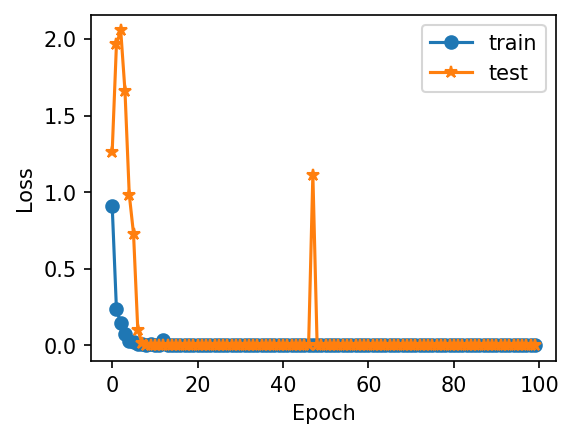

In [41]:
# loss curve
plt.figure(figsize=(4, 3), dpi = 150)
plt.plot(history.history['loss'], marker = 'o', label = 'train')
plt.plot(history.history['val_loss'], marker = '*' ,label =  'test')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

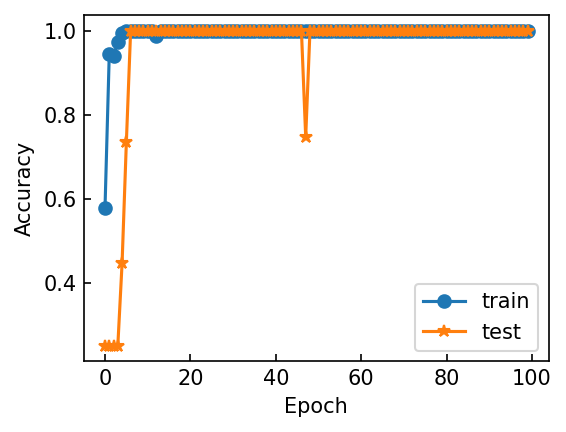

In [57]:
plt.figure(figsize=(4, 3), dpi = 150)
plt.plot(history.history['accuracy'], marker = 'o', label = 'train')
plt.plot(history.history['val_accuracy'], marker = '*', label = 'test')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [49]:
y_pre = model.predict(test_data)
print(y_pre.shape)

10/10 [==============================] - 0s 8ms/step
(320, 4)


In [51]:
y_pre_ = np.argmax(y_pre, axis = 1)
y_pre_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

# Confusion Matrix

In [52]:
from sklearn.metrics import confusion_matrix

In [53]:
def plot_confusion_matrix(true_label, pred_label, class_name):
    y_true = true_label
    y_pred = pred_label
    confusion_mat = confusion_matrix(y_true, y_pred)
    print(confusion_mat)
    
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'
    
    plt.figure(figsize=(4, 3), dpi = 300)
    plt.imshow(confusion_mat, cmap = plt.cm.get_cmap("Blues"))
    plt.colorbar()
    
    indices = range(len(confusion_mat))
    
    plt.xticks(indices, class_name, rotation = 0)
    plt.yticks(indices, class_name)
    
    plt.title("confusion matrix", fontdict={'fontsize': 12})
    plt.xlabel("Predcited label", fontdict={'fontsize': 12})
    plt.ylabel("True label", fontdict= {'fontsize': 12})
    
    for first_index in range(len(confusion_mat)):
        for second_index in range(len(confusion_mat[first_index])):
            if first_index == second_index:
                plt.text(first_index, second_index, confusion_mat[first_index][second_index],
                        color = 'white', fontsize = 12, va = 'center', ha = 'center')
            else:
                plt.text(first_index, second_index, confusion_mat[first_index][second_index],
                        color = 'black', fontsize = 12, va = 'center', ha = 'center')
                
    plt.show()

[[80  0  0  0]
 [ 0 80  0  0]
 [ 0  0 80  0]
 [ 0  0  0 80]]


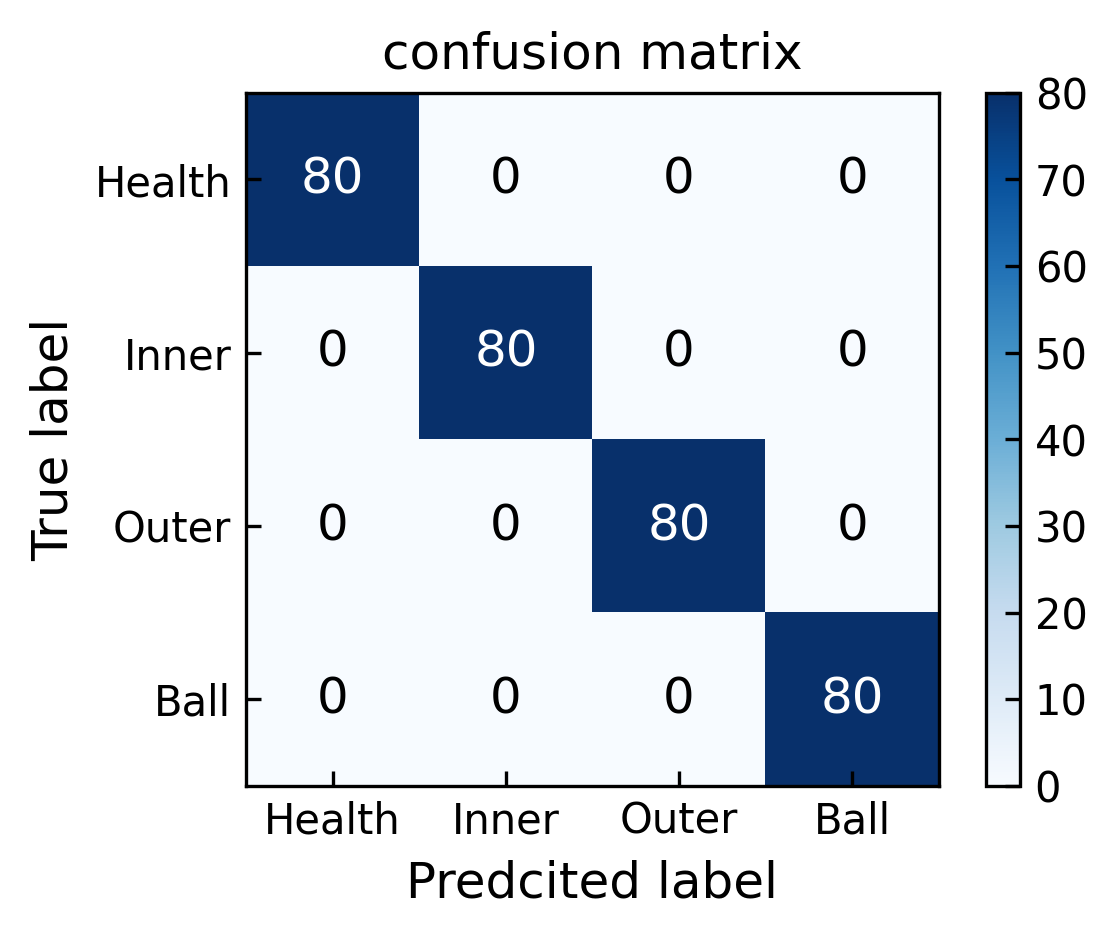

In [54]:
y_true = test_label
y_predict = y_pre_
class_name = ["Health", "Inner", "Outer", "Ball"]
plot_confusion_matrix(y_true, y_predict, class_name)

In [58]:
# save model
model.save("model.h5")